# objective(a) :Using traditional augmentation techniques such as Rotation, Horizontal Flip and Crop.

In [56]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

In [57]:
# Step 1: Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, root_dir, classes_csv, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Read the CSV file
        self.data = pd.read_csv(classes_csv)
        self.filenames = self.data.iloc[:, 0].values
        self.labels = self.data.iloc[:, 1:].values.argmax(axis=1)  # Convert one-hot to integer labels

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        # Load the image and label
        img_path = os.path.join(self.root_dir, self.filenames[idx])
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [58]:
# Step 2: Define Transformations
transformations = {
    "original": transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()]),
    "rotated": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(degrees=30),
        transforms.ToTensor()
    ]),
    "horizontal_flip": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.ToTensor()
    ])
}

In [59]:
#Step 3: Display Sample Images with Transformations
def visualize_transformations(dataset, transformations):
    fig, axes = plt.subplots(len(transformations), 1, figsize=(8, 12))
    sample_idx = np.random.randint(len(dataset))
    img, label = dataset[sample_idx]

    for i, (name, transform) in enumerate(transformations.items()):
        transformed_img = transform(img).permute(1, 2, 0).numpy()
        axes[i].imshow(transformed_img)
        axes[i].set_title(f"Transformation: {name}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
# Step 4: Infer Feature Dimension
def get_feature_dim(model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dummy_input = torch.randn(1, 3, 224, 224).to(device)  # Example input size for ImageNet models
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        features = model(dummy_input)
    return features.shape[1]  # Return the feature dimension

In [ ]:
# Step 5: Zero-Shot Learning
def zero_shot_learning(models, dataloaders, classes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_classes = len(classes)
    
    results = {}
    for transform_name, dataloader in dataloaders.items():
        for model_name, model in models.items():
            # Generate random class prototypes in the feature space
            feature_dim = get_feature_dim(model)
            class_prototypes = torch.randn((feature_dim, num_classes)).to(device)  # Randomly initialized prototypes
            
            model.eval().to(device)
            all_preds, all_labels = [], []
            
            with torch.no_grad():
                for inputs, labels in dataloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    
                    # Extract features from the model
                    features = model(inputs)  # Size: (batch_size, feature_dim)
                    
                    # Project features into the class space by multiplying with class prototypes
                    logits = features @ class_prototypes  # Size: (batch_size, num_classes)
                    
                    # Classify by the highest similarity
                    preds = torch.argmax(logits, dim=1)
                    
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
            
            # Compute metrics
            conf_matrix = confusion_matrix(all_labels, all_preds)
            acc = accuracy_score(all_labels, all_preds)
            precision = precision_score(all_labels, all_preds, average='weighted')
            recall = recall_score(all_labels, all_preds, average='weighted')
            f1 = f1_score(all_labels, all_preds, average='weighted')
            
            results[(transform_name, model_name)] = {
                "confusion_matrix": conf_matrix,
                "accuracy": acc,
                "precision": precision,
                "recall": recall,
                "f1_score": f1
            }
    
    return results

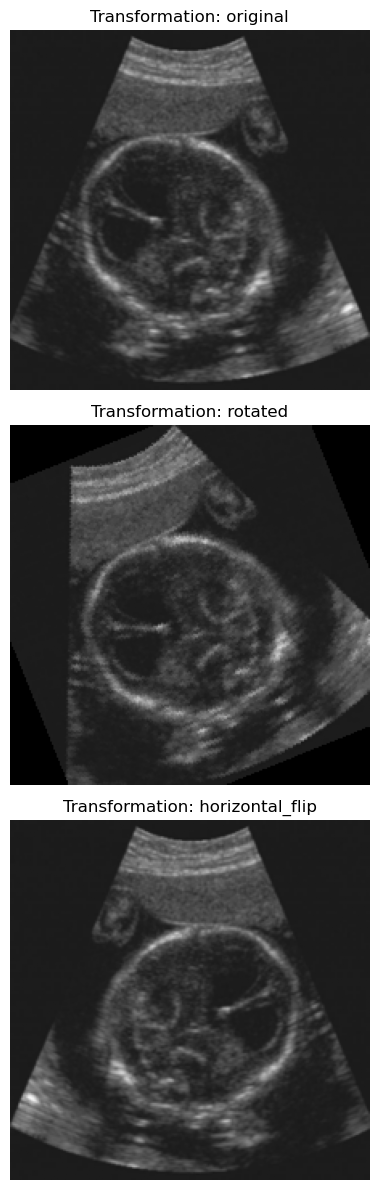

C:\Users\Abhishek Sharma\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Abhishek Sharma\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Abhishek Sharma\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNe


Results for ResNet50 with original transformation:
Accuracy: 0.0216
Precision: 0.0015
Recall: 0.0216
F1-Score: 0.0028


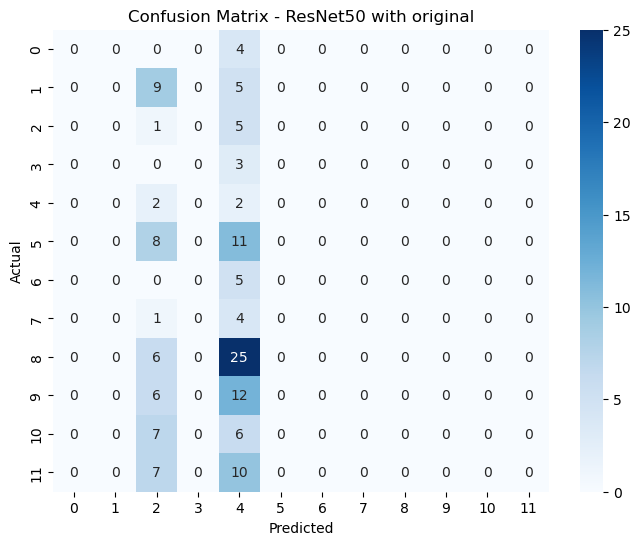


Results for MobileNet_v3_small with original transformation:
Accuracy: 0.0144
Precision: 0.0496
Recall: 0.0144
F1-Score: 0.0223


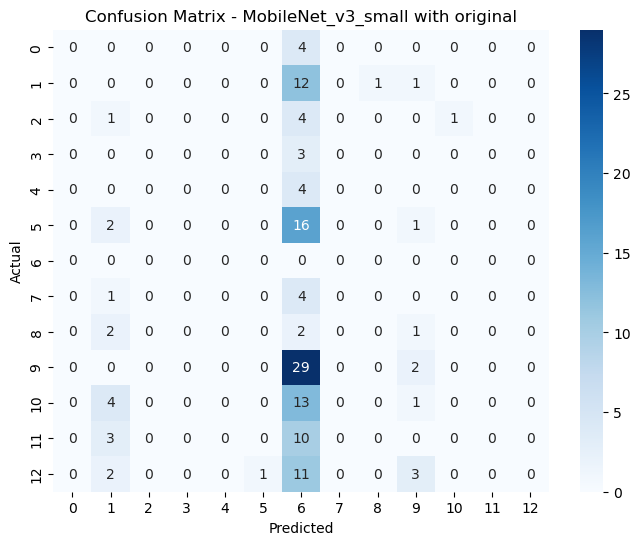


Results for ResNet50 with rotated transformation:
Accuracy: 0.1511
Precision: 0.0795
Recall: 0.1511
F1-Score: 0.0739


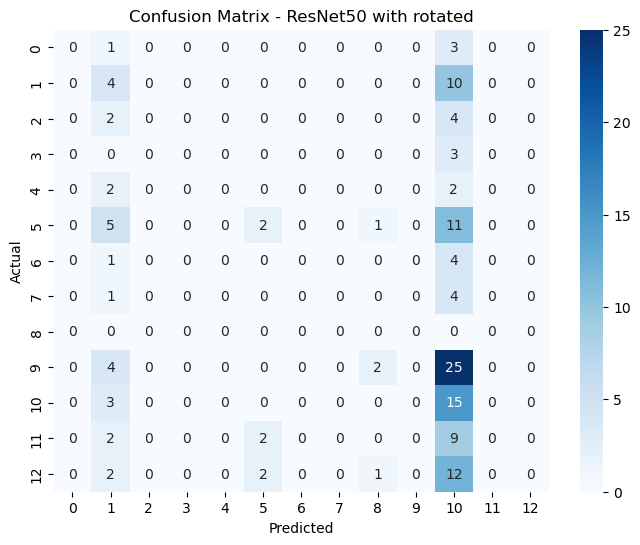


Results for MobileNet_v3_small with rotated transformation:
Accuracy: 0.0647
Precision: 0.0540
Recall: 0.0647
F1-Score: 0.0504


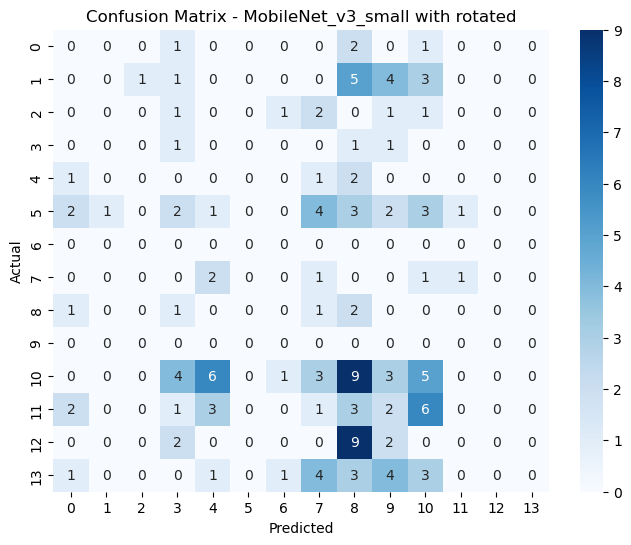


Results for ResNet50 with horizontal_flip transformation:
Accuracy: 0.0000
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000


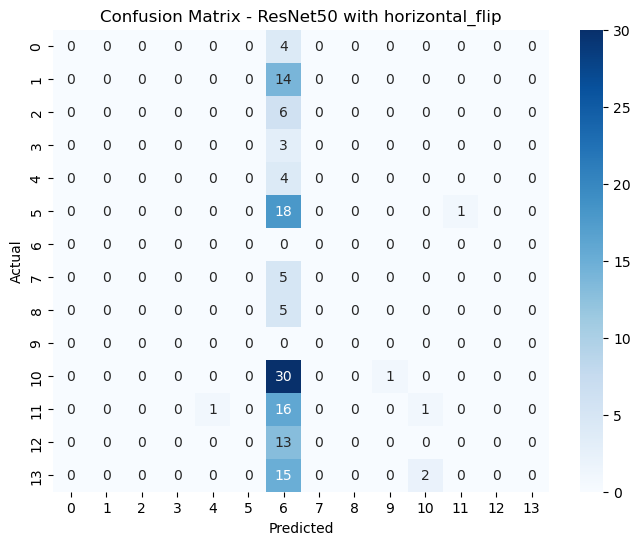


Results for MobileNet_v3_small with horizontal_flip transformation:
Accuracy: 0.1367
Precision: 0.0802
Recall: 0.1367
F1-Score: 0.0854


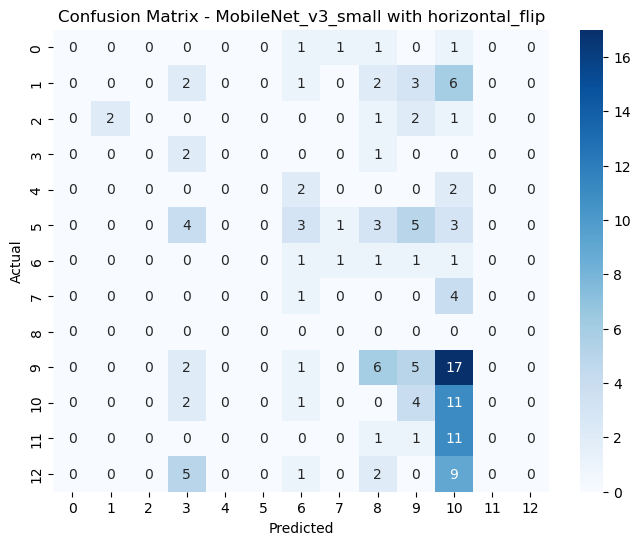

In [60]:
# Step 6: Main Program
if __name__ == "__main__":
    # Paths
    test_data_dir = r"C:\Users\Abhishek Sharma\ATDL_Assignments\archive (1)\test"
    classes_csv = r"C:\Users\Abhishek Sharma\ATDL_Assignments\archive (1)\test_classes\_classes.csv"

    # Load dataset
    dataset = CustomDataset(root_dir=test_data_dir, classes_csv=classes_csv)

    # Visualize transformations
    visualize_transformations(dataset, transformations)

    # DataLoaders for each transformation
    dataloaders = {
        name: DataLoader(
            dataset=CustomDataset(
                root_dir=test_data_dir, 
                classes_csv=classes_csv, 
                transform=transform
            ),
            batch_size=32, shuffle=False
        )
        for name, transform in transformations.items()
    }

    # Pretrained models with feature extraction
    models = {
        "ResNet50": nn.Sequential(
            *(list(models.resnet50(pretrained=True).children())[:-2]),  # Remove last FC and GAP layers
            nn.AdaptiveAvgPool2d((1, 1)),  # Add GAP to produce a fixed-size feature map
            nn.Flatten(),  # Flatten the feature map to 1D
        ),
        "MobileNet_v3_small": nn.Sequential(
            *(list(models.mobilenet_v3_small(pretrained=True).children())[:-2]),  # Remove last FC and GAP layers
            nn.AdaptiveAvgPool2d((1, 1)),  # Add GAP to produce a fixed-size feature map
            nn.Flatten(),  # Flatten the feature map to 1D
        )
    }

    # Perform Zero-Shot Learning
    results = zero_shot_learning(models, dataloaders, np.unique(dataset.labels))
    
    # Display Results
    for (transform_name, model_name), metrics in results.items():
        print(f"\nResults for {model_name} with {transform_name} transformation:")
        print(f"Accuracy: {metrics['accuracy']:.4f}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1-Score: {metrics['f1_score']:.4f}")
        
        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(metrics["confusion_matrix"], annot=True, fmt="d", cmap="Blues")
        plt.title(f"Confusion Matrix - {model_name} with {transform_name}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()


# objective(b) : Using Advanced augmentation techniques of Mixup

In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as pretrained_models_module
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import random

In [ ]:
# Step 1: Mixup Dataset Class
class MixupDataset(Dataset):
    def __init__(self, root_dir, classes_csv, transform=None, mixup_alpha=0.2):
        self.root_dir = root_dir
        self.transform = transform
        self.mixup_alpha = mixup_alpha

        # Read the CSV file
        self.data = pd.read_csv(classes_csv)
        self.filenames = self.data.iloc[:, 0].values
        self.labels = self.data.iloc[:, 1:].values

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        # Randomly select a second image for Mixup
        mixup_idx = random.randint(0, len(self.filenames) - 1)

        # Load images and labels
        img1_path = os.path.join(self.root_dir, self.filenames[idx])
        img2_path = os.path.join(self.root_dir, self.filenames[mixup_idx])
        image1 = Image.open(img1_path).convert("RGB")
        image2 = Image.open(img2_path).convert("RGB")
        label1 = torch.tensor(self.labels[idx], dtype=torch.float32)
        label2 = torch.tensor(self.labels[mixup_idx], dtype=torch.float32)

        # Apply transformations
        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)

        # Apply Mixup
        lam = np.random.beta(self.mixup_alpha, self.mixup_alpha)
        mixed_image = lam * image1 + (1 - lam) * image2
        mixed_label = lam * label1 + (1 - lam) * label2

        return mixed_image, mixed_label

In [ ]:
# Step 2: Define Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [ ]:
# Step 3: Visualize Mixup Augmentation
def visualize_mixup(dataset):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    for i in range(3):
        image, label = dataset[np.random.randint(len(dataset))]
        axes[i].imshow(image.permute(1, 2, 0).numpy())
        axes[i].set_title(f"Mixed Image {i+1}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
# Step 4: Get Pretrained Models
def get_pretrained_models():
    return {
        "ResNet50": nn.Sequential(
            *(list(pretrained_models_module.resnet50(pretrained=True).children())[:-2]),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        ),
        "MobileNet_v3_small": nn.Sequential(
            *(list(pretrained_models_module.mobilenet_v3_small(pretrained=True).children())[:-2]),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        )
    }

In [ ]:
# Step 5: Infer Feature Dimension
def get_feature_dim(model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dummy_input = torch.randn(1, 3, 224, 224).to(device)  # Example input size for ImageNet models
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        features = model(dummy_input)
    return features.shape[1]  # Return the feature dimension

In [ ]:
# Step 6: Zero-Shot Learning
def zero_shot_learning(pretrained_models, dataloader, num_classes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    results = {}

    for model_name, model in pretrained_models.items():
        # Dynamically determine feature dimension
        feature_dim = get_feature_dim(model)
        class_prototypes = torch.randn((feature_dim, num_classes)).to(device)  # Randomly initialized prototypes

        model.eval().to(device)
        all_preds, all_labels = [], []

        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Extract features
                features = model(inputs)

                # Project features into class space
                logits = features @ class_prototypes

                # Predictions
                preds = torch.argmax(logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(torch.argmax(labels, dim=1).cpu().numpy())

        # Metrics
        conf_matrix = confusion_matrix(all_labels, all_preds)
        acc = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')

        results[model_name] = {
            "confusion_matrix": conf_matrix,
            "accuracy": acc,
            "precision": precision,
            "recall": recall,
            "f1_score": f1
        }
    return results

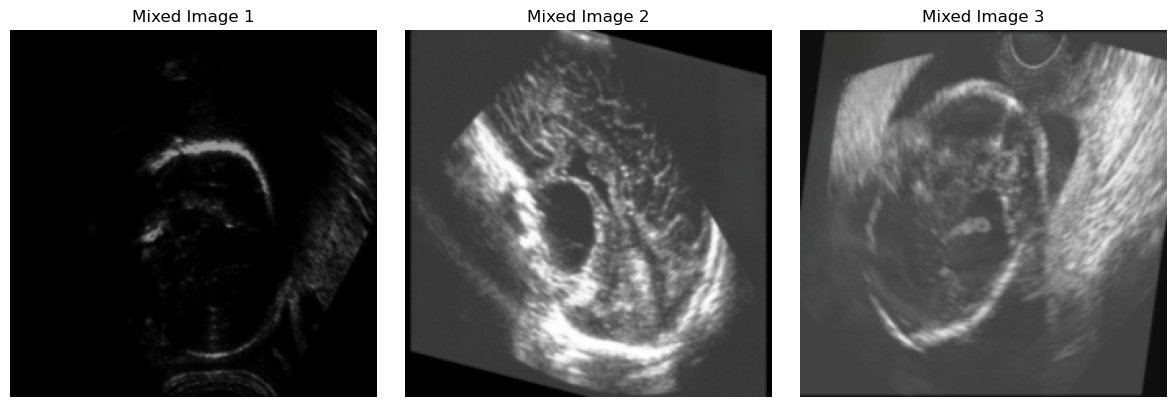

C:\Users\Abhishek Sharma\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Abhishek Sharma\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Abhishek Sharma\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNe


Model: ResNet50
Accuracy: 0.0360
Precision: 0.0029
Recall: 0.0360
F1-Score: 0.0049


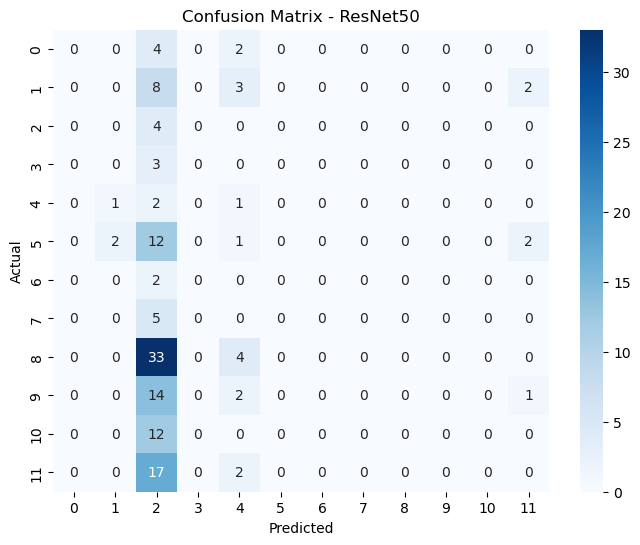


Model: MobileNet_v3_small
Accuracy: 0.0360
Precision: 0.0133
Recall: 0.0360
F1-Score: 0.0193


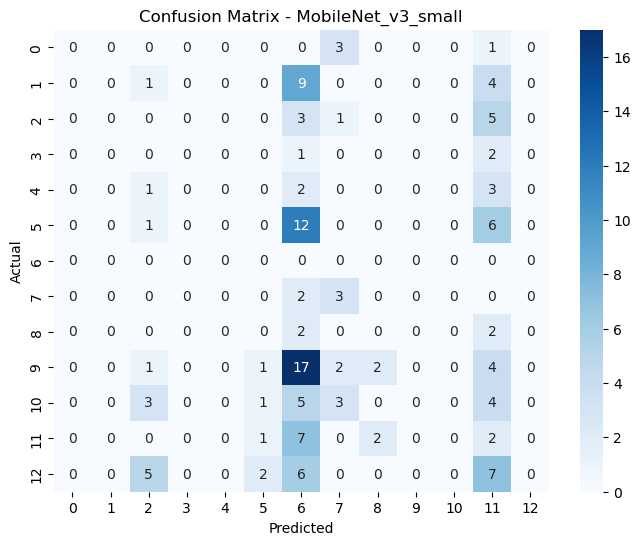

In [47]:
# Step 7: Main Program
if __name__ == "__main__":
    # Paths
    test_data_dir = r"C:\Users\Abhishek Sharma\ATDL_Assignments\archive (1)\test"
    classes_csv = r"C:\Users\Abhishek Sharma\ATDL_Assignments\archive (1)\test_classes\_classes.csv"

    # Dataset and DataLoader
    dataset = MixupDataset(test_data_dir, classes_csv, transform=transform)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

    # Visualize Mixup
    visualize_mixup(dataset)

    # Load pretrained models
    pretrained_models = get_pretrained_models()

    # Perform Zero-Shot Learning
    num_classes = dataset.labels.shape[1]
    results = zero_shot_learning(pretrained_models, dataloader, num_classes)

    # Display Results
    for model_name, metrics in results.items():
        print(f"\nModel: {model_name}")
        print(f"Accuracy: {metrics['accuracy']:.4f}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1-Score: {metrics['f1_score']:.4f}")

        # Confusion Matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(metrics["confusion_matrix"], annot=True, fmt="d", cmap="Blues")
        plt.title(f"Confusion Matrix - {model_name}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()


# objective(b) : Using Advanced augmentation techniques of CutMix

In [48]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as pretrained_models_module
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import random


In [49]:
class CutMixDataset(Dataset):
    def __init__(self, root_dir, classes_csv, transform=None, beta=1.0):
        self.root_dir = root_dir
        self.transform = transform
        self.beta = beta

        # Read the CSV file
        self.data = pd.read_csv(classes_csv)
        self.filenames = self.data.iloc[:, 0].values
        self.labels = self.data.iloc[:, 1:].values

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        # Select two images randomly
        img1_idx = idx
        img2_idx = random.randint(0, len(self.filenames) - 1)

        # Load images and labels
        img1_path = os.path.join(self.root_dir, self.filenames[img1_idx])
        img2_path = os.path.join(self.root_dir, self.filenames[img2_idx])
        image1 = Image.open(img1_path).convert("RGB")
        image2 = Image.open(img2_path).convert("RGB")
        label1 = torch.tensor(self.labels[img1_idx], dtype=torch.float32)
        label2 = torch.tensor(self.labels[img2_idx], dtype=torch.float32)

        # Apply transformations
        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)

        # Apply CutMix
        lam = np.random.beta(self.beta, self.beta)
        _, H, W = image1.shape
        cut_rat = np.sqrt(1.0 - lam)
        cut_w = int(W * cut_rat)
        cut_h = int(H * cut_rat)

        # Randomly choose the rectangle position
        cx = np.random.randint(W)
        cy = np.random.randint(H)
        x1 = np.clip(cx - cut_w // 2, 0, W)
        x2 = np.clip(cx + cut_w // 2, 0, W)
        y1 = np.clip(cy - cut_h // 2, 0, H)
        y2 = np.clip(cy + cut_h // 2, 0, H)

        # Replace the rectangle region
        mixed_image = image1.clone()
        mixed_image[:, y1:y2, x1:x2] = image2[:, y1:y2, x1:x2]
        lam = 1 - ((x2 - x1) * (y2 - y1) / (W * H))  # Adjust lambda

        # Mixed label
        mixed_label = lam * label1 + (1 - lam) * label2

        return mixed_image, mixed_label


In [50]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


In [51]:
def visualize_cutmix(dataset):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    for i in range(3):
        image, label = dataset[np.random.randint(len(dataset))]
        axes[i].imshow(image.permute(1, 2, 0).numpy())
        axes[i].set_title(f"CutMix Image {i+1}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()


In [52]:
def get_pretrained_models():
    return {
        "ResNet50": nn.Sequential(
            *(list(pretrained_models_module.resnet50(pretrained=True).children())[:-2]),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        ),
        "MobileNet_v3_small": nn.Sequential(
            *(list(pretrained_models_module.mobilenet_v3_small(pretrained=True).children())[:-2]),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        )
    }

In [53]:
def get_feature_dim(model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dummy_input = torch.randn(1, 3, 224, 224).to(device)
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        features = model(dummy_input)
    return features.shape[1]  # Return the feature dimension


In [54]:
def zero_shot_learning(pretrained_models, dataloader, num_classes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    results = {}

    for model_name, model in pretrained_models.items():
        # Dynamically determine feature dimension
        feature_dim = get_feature_dim(model)
        class_prototypes = torch.randn((feature_dim, num_classes)).to(device)  # Randomly initialized prototypes

        model.eval().to(device)
        all_preds, all_labels = [], []

        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Extract features
                features = model(inputs)

                # Project features into class space
                logits = features @ class_prototypes

                # Predictions
                preds = torch.argmax(logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(torch.argmax(labels, dim=1).cpu().numpy())

        # Metrics
        conf_matrix = confusion_matrix(all_labels, all_preds)
        acc = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')

        results[model_name] = {
            "confusion_matrix": conf_matrix,
            "accuracy": acc,
            "precision": precision,
            "recall": recall,
            "f1_score": f1
        }
    return results


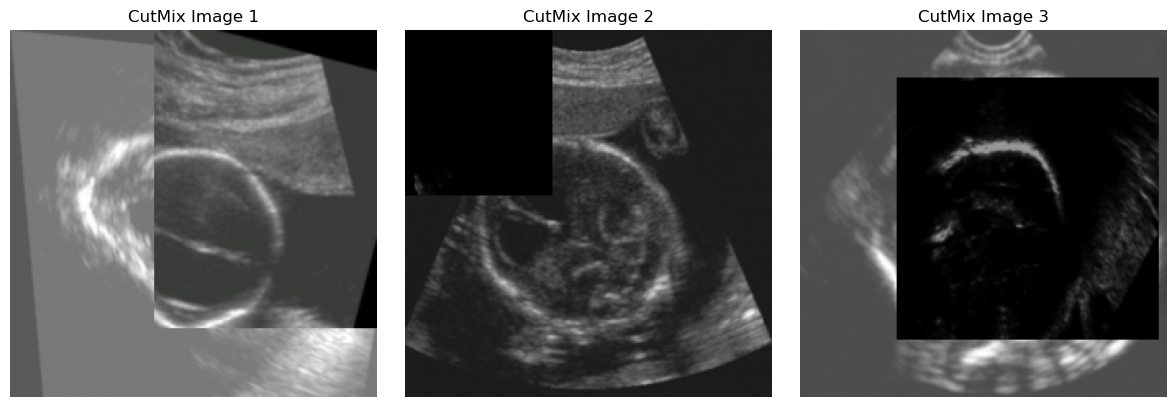

C:\Users\Abhishek Sharma\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Abhishek Sharma\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Abhishek Sharma\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNe


Model: ResNet50
Accuracy: 0.1151
Precision: 0.0327
Recall: 0.1151
F1-Score: 0.0420


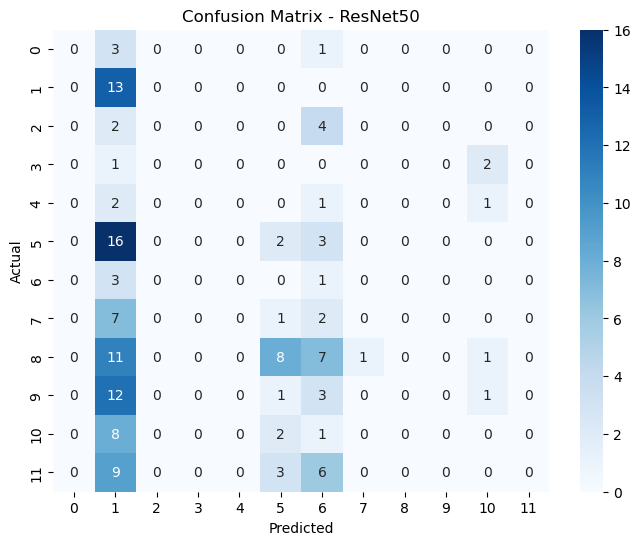


Model: MobileNet_v3_small
Accuracy: 0.0719
Precision: 0.0258
Recall: 0.0719
F1-Score: 0.0312


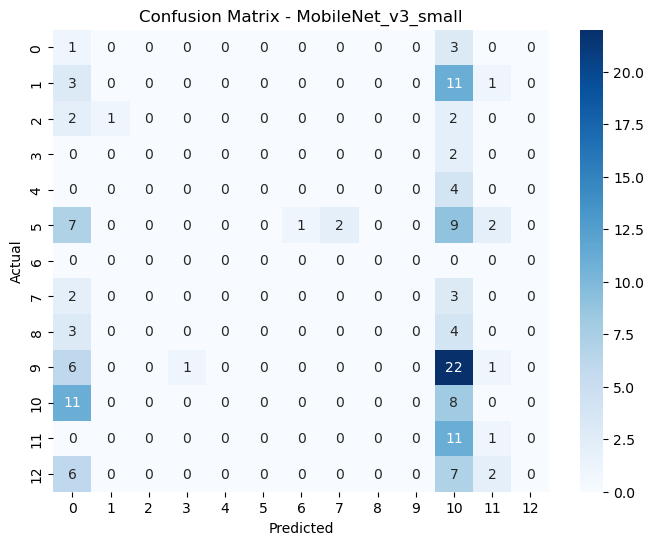

In [55]:
if __name__ == "__main__":
    # Paths
    test_data_dir = r"C:\Users\Abhishek Sharma\ATDL_Assignments\archive (1)\test"
    classes_csv = r"C:\Users\Abhishek Sharma\ATDL_Assignments\archive (1)\test_classes\_classes.csv"

    # Dataset and DataLoader
    dataset = CutMixDataset(test_data_dir, classes_csv, transform=transform)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

    # Visualize CutMix
    visualize_cutmix(dataset)

    # Load pretrained models
    pretrained_models = get_pretrained_models()

    # Perform Zero-Shot Learning
    num_classes = dataset.labels.shape[1]
    results = zero_shot_learning(pretrained_models, dataloader, num_classes)

    # Display Results
    for model_name, metrics in results.items():
        print(f"\nModel: {model_name}")
        print(f"Accuracy: {metrics['accuracy']:.4f}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1-Score: {metrics['f1_score']:.4f}")

        # Confusion Matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(metrics["confusion_matrix"], annot=True, fmt="d", cmap="Blues")
        plt.title(f"Confusion Matrix - {model_name}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()


# objective(c) :Use Few Shot learning to train the models .

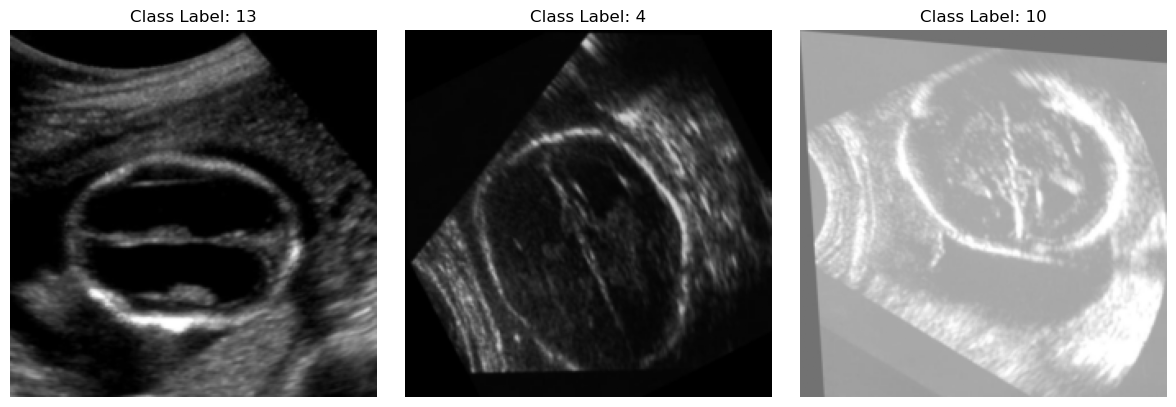

C:\Users\Abhishek Sharma\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Abhishek Sharma\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Abhishek Sharma\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNe

Epoch 1/15, Loss: 2.9441
Epoch 2/15, Loss: 2.8526
Epoch 3/15, Loss: 2.6402
Epoch 4/15, Loss: 2.5458
Epoch 5/15, Loss: 2.4575
Epoch 6/15, Loss: 2.3195
Epoch 7/15, Loss: 2.2352
Epoch 8/15, Loss: 2.0640
Epoch 9/15, Loss: 2.0516
Epoch 10/15, Loss: 1.7917
Epoch 11/15, Loss: 1.6673
Epoch 12/15, Loss: 1.6249
Epoch 13/15, Loss: 1.5288
Epoch 14/15, Loss: 1.3699
Epoch 15/15, Loss: 1.3366


C:\Users\Abhishek Sharma\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Abhishek Sharma\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Model: ResNet50
Accuracy: 0.1295
Precision: 0.1834
Recall: 0.1295
F1-Score: 0.1395


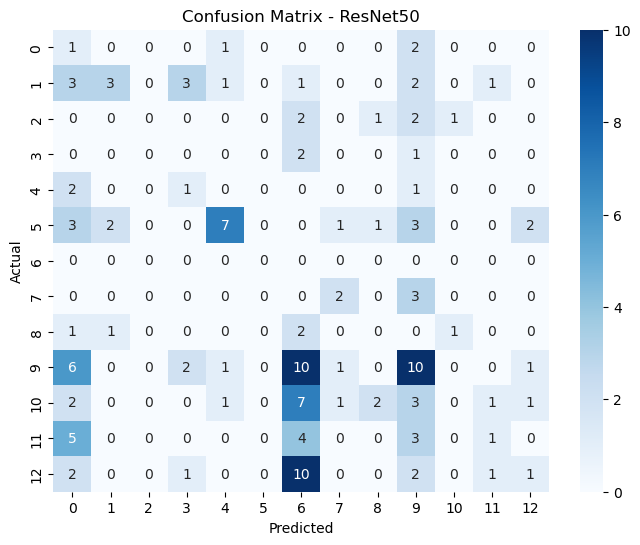

Epoch 1/15, Loss: 2.5907
Epoch 2/15, Loss: 1.6059
Epoch 3/15, Loss: 0.8994
Epoch 4/15, Loss: 0.4104
Epoch 5/15, Loss: 0.1933
Epoch 6/15, Loss: 0.0699
Epoch 7/15, Loss: 0.0606
Epoch 8/15, Loss: 0.0567
Epoch 9/15, Loss: 0.0524
Epoch 10/15, Loss: 0.0647
Epoch 11/15, Loss: 0.0550
Epoch 12/15, Loss: 0.0404
Epoch 13/15, Loss: 0.0386
Epoch 14/15, Loss: 0.0307
Epoch 15/15, Loss: 0.0625


C:\Users\Abhishek Sharma\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Model: MobileNet_v3_small
Accuracy: 0.2302
Precision: 0.5862
Recall: 0.2302
F1-Score: 0.2161


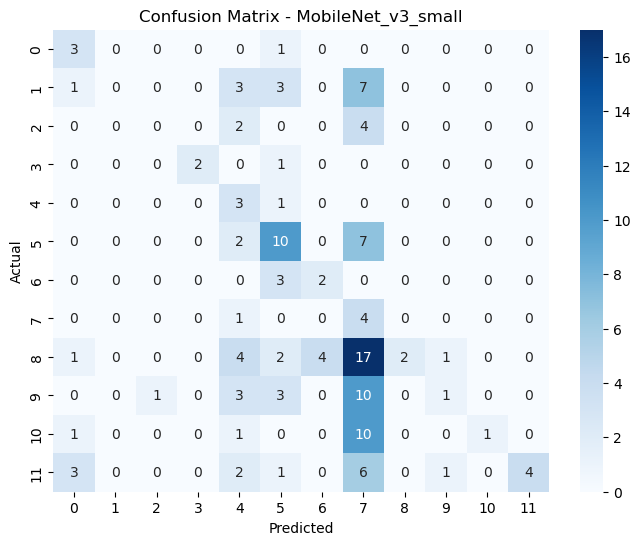

In [74]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
import torchvision.models as pretrained_models_module
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from collections import defaultdict
from random import shuffle

# **Step 1: Few-Shot Dataset Class**
class FewShotDataset(Dataset):
    def __init__(self, root_dir, classes_csv, transform=None):
        """
        Dataset for Few-Shot Learning.
        Args:
            root_dir (str): Path to the folder containing the images.
            classes_csv (str): Path to the CSV file with filename-to-class mappings.
            transform (callable, optional): Transformations to apply to images.
        """
        self.root_dir = root_dir
        self.transform = transform

        # Read the CSV file
        self.data = pd.read_csv(classes_csv)
        self.filenames = self.data.iloc[:, 0].values
        self.labels = self.data.iloc[:, 1:].values.argmax(axis=1)  # Convert one-hot to integer labels

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        # Load image and label
        img_path = os.path.join(self.root_dir, self.filenames[idx])
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# **Step 2: Few-Shot Sampling**
def create_few_shot_dataset(dataset, n_per_class):
    """
    Create a Few-Shot Learning dataset with limited samples per class.
    Args:
        dataset (Dataset): The full dataset.
        n_per_class (int): Number of samples per class.
    Returns:
        Subset: A subset of the dataset with n_per_class samples per class.
    """
    class_indices = defaultdict(list)
    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)

    few_shot_indices = []
    for class_idx, indices in class_indices.items():
        shuffle(indices)
        few_shot_indices.extend(indices[:n_per_class])

    return Subset(dataset, few_shot_indices)

# **Step 3: Define Transformations**
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# **Step 4: Visualize Random Images**
def visualize_random_images(dataset):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    for i in range(3):
        image, label = dataset[np.random.randint(len(dataset))]
        axes[i].imshow(image.permute(1, 2, 0).numpy())
        axes[i].set_title(f"Class Label: {label}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# **Step 5: Load Pretrained Models**
def get_pretrained_models(num_classes):
    """
    Initialize and return pretrained ResNet50 and MobileNet v3-small models.
    Modify the output layers to match the number of classes.
    """
    return {
        "ResNet50": nn.Sequential(
            *(list(pretrained_models_module.resnet50(pretrained=True).children())[:-1]),
            nn.Flatten(),
            nn.Linear(2048, num_classes)  # Fine-tune with the number of classes
        ),
        "MobileNet_v3_small": nn.Sequential(
            *(list(pretrained_models_module.mobilenet_v3_small(pretrained=True).children())[:-1]),
            nn.Flatten(),
            nn.Linear(576, num_classes)  # Fine-tune with the number of classes
        )
    }

# **Step 6: Train and Evaluate Models**
def train_and_evaluate(models, train_loader, test_loader, num_epochs=5, learning_rate=0.001):
    """
    Train and evaluate the models on the Few-Shot Learning dataset.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    results = {}

    for model_name, model in models.items():
        model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()

        # Training Loop
        model.train()
        for epoch in range(num_epochs):
            running_loss = 0.0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")

        # Evaluation
        model.eval()
        all_preds, all_labels = [], []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                preds = torch.argmax(outputs, dim=1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Compute Metrics
        conf_matrix = confusion_matrix(all_labels, all_preds)
        acc = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')

        results[model_name] = {
            "confusion_matrix": conf_matrix,
            "accuracy": acc,
            "precision": precision,
            "recall": recall,
            "f1_score": f1
        }

        print(f"\nModel: {model_name}")
        print(f"Accuracy: {acc:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")

        # Confusion Matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
        plt.title(f"Confusion Matrix - {model_name}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

    return results

# **Step 7: Main Program**
if __name__ == "__main__":
    # Paths
    train_data_dir = r"E:\ATDL_Assignments\CS24MS003_ATDL_Assignment_01\archive (1)\train"
    test_data_dir = r"E:\ATDL_Assignments\CS24MS003_ATDL_Assignment_01\archive (1)\test"
    train_classes_csv = r"E:\ATDL_Assignments\CS24MS003_ATDL_Assignment_01\archive (1)\train\_classes.csv"
    test_classes_csv = r"E:\ATDL_Assignments\CS24MS003_ATDL_Assignment_01\archive (1)\test\_classes.csv"

    # Load Datasets and DataLoaders
    train_dataset = FewShotDataset(train_data_dir, train_classes_csv, transform=transform)
    test_dataset = FewShotDataset(test_data_dir, test_classes_csv, transform=transform)

    # Limit training dataset to few-shot samples per class
    n_per_class = 15  # Number of samples per class for few-shot learning
    train_dataset = create_few_shot_dataset(train_dataset, n_per_class=n_per_class)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    # Visualize Random Images
    visualize_random_images(train_dataset)

    # Load pretrained models
    num_classes = len(pd.read_csv(train_classes_csv).columns) - 1  # Exclude filename column
    pretrained_models = get_pretrained_models(num_classes)

    # Train and Evaluate Models
    results = train_and_evaluate(pretrained_models, train_loader, test_loader, num_epochs=15, learning_rate=0.001)
